In [14]:
import xarray as xr
import numpy as np
import pandas as pd
import os, sys
from os.path import join, basename
import matplotlib.pyplot as plt
import hydromt
from hydromt import DataCatalog
from hydromt_sfincs import SfincsModel
from hydromt_sfincs.utils import parse_datetime
import datetime
from datetime import timedelta
from hydromt.log import setuplog
import matplotlib.pyplot as plt
sys.path.append('./eva_script')

from eva_script import eva

In [15]:
#We open the file with the events
events = xr.open_dataarray('P:/11206881-climate-risk-in-cities/msc_theses/Jasper/hydromt_sfincs-main/Case_studies/sfincs_update_bangkok_wg_historic_1/boundary_conditions/fluvial_design_events.nc').reset_coords(drop=True)

In [28]:
#These times are the start and end of your simulation

t_peak = '20100101 000000'
t0 = parse_datetime(t_peak)

In [29]:
#We need to convert the time index (relative to the peak to a datetime index)
sel_rp = 100
q0 = events.sel(rps=sel_rp).reset_coords(drop=True).to_series().unstack(0)   #We convert the xr.dataarray to a pd.dataframe
q0.index = t0 + np.array([timedelta(days=int(dt)) for dt in q0.index.values]) #We convert the index to a date
#Looking at the index of q0, you see now that the event starts on 2019/12/21 and ends on 2020/01/10
print('Peak date is:', t_peak)
print('Start date is:', q0.index[0])
print('End date is:',  q0.index[-1])

Peak date is: 20100101 000000
Start date is: 2009-12-21 00:00:00
End date is: 2010-01-10 00:00:00


In [30]:
#Note that (tstop - tstart) correspond to the window size picked in the eva (wdw_size)
tstart = q0.index[0].strftime("%Y%m%d %H%M%S") 
tstop = q0.index[-1].strftime("%Y%m%d %H%M%S") 
#These times are suggested only: you can also select other start and end time as long as there is data!

In [32]:
#Load the basemodel
mdir = r"sfincs_update_bangkok_wg_historic_1" #Initial model
new_root = f'{mdir}_design_event_rp{sel_rp}'
logger = setuplog('update', join(mdir, "hydromt.log"), log_level=10)

2022-06-07 14:30:50,992 - update - log - DEBUG - Appending log messages to file sfincs_update_bangkok_wg_historic_1\hydromt.log.
2022-06-07 14:30:51,013 - update - log - INFO - HydroMT version: 0.4.6.dev


In [34]:
#read teh original model
mod1 = SfincsModel(join(mdir), mode='r', deltares_data=True, logger=logger)
mod1.read()
# update model time to the tstart-tstop
# NOTE that you need to check the timing of other (precip and waterlevel) boundary conditions 
mod1.setup_config(
    tref=tstart,
    tstart=tstart,
    tstop=tstop
)

2022-06-07 14:31:15,791 - update - data_adapter - INFO - Adding deltares_data v0.0.6 sources from https://github.com/DirkEilander/hydromt-artifacts/releases/download/v0.0.6/deltares_data.yml
2022-06-07 14:31:16,809 - update - data_adapter - WARNING - Overwriting data source era5_hourly.
2022-06-07 14:31:16,816 - update - data_adapter - WARNING - Overwriting data source fabdem.
2022-06-07 14:31:16,823 - update - data_adapter - WARNING - Overwriting data source gcn250.
2022-06-07 14:31:16,829 - update - data_adapter - WARNING - Overwriting data source merit_hydro.
2022-06-07 14:31:16,841 - update - data_adapter - WARNING - Overwriting data source osm_coastlines.
2022-06-07 14:31:16,850 - update - data_adapter - WARNING - Overwriting data source rivers_lin2019_v1.
2022-06-07 14:31:16,857 - update - data_adapter - WARNING - Overwriting data source vito.
2022-06-07 14:31:16,868 - update - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.2.1).
2022-06-07 14:31:16,913 - up

In [35]:
#We extract the locations of the points
gdf_q = mod1.forcing['dis'].vector.to_gdf()
gdf_h = mod1.forcing['bzs'].vector.to_gdf()


In [36]:
#To update a discharge BC
mod1.set_forcing_1d(ts=q0.copy(), xy=gdf_q, name='discharge') 
mod1.forcing['dis'] = mod1.forcing['dis'].fillna(0.0)

2022-06-07 14:32:21,955 - update - sfincs - DEBUG - discharge forcing: setting src data for 1 points.
2022-06-07 14:32:21,972 - update - sfincs - DEBUG - discharge forcing: setting dis data.
2022-06-07 14:32:21,977 - update - model_api - WARNING - Replacing forcing: dis


In [37]:
# set a zero waterlevel boundary, as we are only interested in Q
mod1.set_forcing_1d(xy=gdf_h, name='waterlevel')

2022-06-07 14:34:55,888 - update - sfincs - DEBUG - waterlevel forcing: setting bnd data for 6 points.
2022-06-07 14:34:55,908 - update - sfincs - DEBUG - waterlevel forcing: setting bzs data.
2022-06-07 14:34:55,915 - update - model_api - WARNING - Replacing forcing: bzs


In [38]:
# remove precip as we are only interested in Q
if 'precip' in mod1.forcing:
    mod1.forcing.pop('precip')
    mod1.config.pop('precipfile', None)

In [39]:
# update model and save
mod1.set_root(new_root)
mod1.write_forcing()
mod1.write_config(rel_path=f'../{basename(mdir)}')

2022-06-07 14:37:32,152 - update - log - DEBUG - Writing log messages to new file p:\11206881-climate-risk-in-cities\msc_theses\Jasper\hydromt_sfincs-main\Case_studies\sfincs_update_bangkok_wg_historic_1_design_event_rp100\hydromt.log.
2022-06-07 14:37:32,156 - update - sfincs - INFO - Write forcing files
2022-06-07 14:37:32,290 - update - sfincs - INFO - Write vector file(s) for forcing.bzs to 'gis' subfolder
2022-06-07 14:37:32,355 - update - sfincs - INFO - Write vector file(s) for forcing.dis to 'gis' subfolder
2022-06-07 14:37:32,761 - update - model_api - INFO - Writing model config to p:\11206881-climate-risk-in-cities\msc_theses\Jasper\hydromt_sfincs-main\Case_studies\sfincs_update_bangkok_wg_historic_1_design_event_rp100\sfincs.inp


(<Figure size 432x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>,
        <AxesSubplot:title={'center':'SFINCS discharge forcing (dis)'}, ylabel='discharge\n[m3.s-1]'>],
       dtype=object))

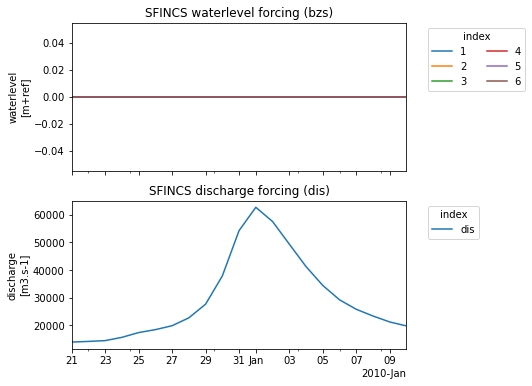

In [40]:
# check if forcing looks as expected
mod1.plot_forcing()